In [2]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt

# ITOF (Indirect Time Of Flight)

Cilj nam je, da želimo iz modulirnih signalov in odbitega signala iračunati spremembo faze odbitega signala, s pomočjo katere lahko potem izračunamo oddaljenost predmeta, od katerega se je signal odbil. 

To bomo dosegli tako, da izračunamo integral produkta modulirnega signala (z isto fazo kot jo ima oddan signal) in odbitega signala ter integral produkta modulirnega signala (s faznim zamikom $\pi/2$ glede na oddan signal) in odbitega signala, ter nato delimo dobljena rezultata:

![](../img/shema1.png)

Parametri, ki določajo oddan signal $T$ so $I$ (amplituda oddanega signala) in $f_m$ (frekvenca oddanega signala). Modulirne signale določimo tako, da imajo frekvenco enako oddanemu signalu, njihova amplituda pa ni pomembna, ker se nam bo v nadaljevanju pokrajšala.

Amplituda odbitega signala $R$ je spremenjena za faktor $\delta$, ki je odvisen od predmeta od katerega se obije signal, in za $A$, ki predstavlja ambientno svetlobo, vendar nam te spremembe ne povzročajo težav, ker se pri izračunih pokrajšajo.

\begin{align*}
Q_0 &= \int_0^{T_{int}} RS dt = \dfrac{\delta I}{2}  \cos(\Delta \varphi)  T_{int} \\
Q_{90} &= \int_0^{T_{int}} RS dt = \dfrac{\delta I}{2}  \cos(\Delta \varphi - \dfrac{\pi}{2})  T_{int} = \dfrac{\delta I}{2}  \sin(\Delta \varphi)  T_{int}
\end{align*}

Spremembo faze in oddaljenost predmeta lahko izračunamo po enačbah:

$$ \Delta \varphi = \arctg(\dfrac{Q_{90}}{Q_0})$$
$$ d = \dfrac{c \Delta \varphi}{4 \pi f_m}$$

## Generiranje signalov

Da lahko začnemo z izračuni, moramo najprej generirati različne signale. S prvo funkcijo bomo generirali oddan in modulirne signale, ki so konstanti po tem ko definiramo parametre laserja, z drugo pa odbit signal, ki se spreminja glede na oddaljenost predmeta.

Določiti pa moramo tudi parametre laserja in število period, ki jih bomo simulirali.

### Konstante

In [3]:
# Parametri laserja
f = 1e7     # frekvenca [Hz]
I = 0.5     # amplituda

wl = sc.c / f  # valovna dolžina [m]
tp = 1 / f     # perioda [s]
pp = 100000    # število točk na periodo
Np = 10        # število period

# Časovna os
t = np.linspace(0, Np*tp, Np*pp)    # čas [s]
t_ns = t * 1e9                      # čas [ns]

In [4]:
print("Parametri laserja:")
print(" - Frekvenca:       {:.2f} MHz".format(f*1e-6))
print(" - Valovna dolžina: {:.2f} m".format(wl))
print(" - Perioda:         {:.2f} ns".format(tp*1e9))

Parametri laserja:
 - Frekvenca:       10.00 MHz
 - Valovna dolžina: 29.98 m
 - Perioda:         100.00 ns


### Generiranje signalov

In [5]:
def get_laser_signals(t, f, I):
    """
    Generates the signals for the IToF system.
    t ... time
    f ... frequency
    I ... transmision signal intensity

    returns:
    T    ... Transmision signal
    S_0  ... 0 phase modulation signal 
    S_90 ... 90 phase modulation signal
    """
    T = I * np.sin(2 * np.pi * f * t)

    S_0 = np.sin(2 * np.pi * f * t)
    S_1 = np.sin(2 * np.pi * f * t - np.pi / 2)

    return T, S_0, S_1

In [6]:
def phase_change(f, d):
    """
    Calculate the phase change of a wave with frequency f that reflected off an object at distance d.
    """
    return 4 * np.pi * f * d / sc.c

In [7]:
def get_reflected_signal(t, f, I, d):
    """
    Generates the reflected signal for the IToF system.
    t ... time
    f ... frequency
    I ... transmision signal intensity
    d ... distance

    returns:
    R    ... Reflected signal
    """
    R = I * np.sin(2 * np.pi * f * t - phase_change(f, d))

    return R

### Vizualizacija

In [8]:
def plot1():
    s_t, s_m_0, s_m_90 = get_laser_signals(t, f, I)
    s_r = get_reflected_signal(t, f, I, 6)

    s_rs = s_r * s_m_0 
    s_r90s = s_r * s_m_90

    n_periods = 2

    plt.figure(figsize=(12, 8))

    plt.subplot(2,2,1)
    plt.title("Transmited and modulation signals")
    plt.plot(t_ns[:n_periods*pp], s_m_0[:n_periods*pp], label="0 phase modulated signal", color="#55a9aa")
    plt.plot(t_ns[:n_periods*pp], s_m_90[:n_periods*pp], label="90 phase modulated signal", color="orange")
    plt.plot(t_ns[:n_periods*pp], s_t[:n_periods*pp], label="Transmitted signal", color="#2444ca", linewidth=3)
    plt.xlabel("Time [ns]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()

    plt.subplot(2,2,2)
    plt.title("Reflected and modulation signals")
    plt.plot(t_ns[:n_periods*pp], s_m_0[:n_periods*pp], label="0 phase modulated signal", color="#55a9aa")
    plt.plot(t_ns[:n_periods*pp], s_m_90[:n_periods*pp], label="90 phase modulated signal", color="#55797a")
    plt.plot(t_ns[:n_periods*pp], s_r[:n_periods*pp], label="Reflected signal", color="#ca2444", linewidth=3)
    plt.xlabel("Time [ns]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()

    plt.subplot(2,1,2)
    plt.title("Product of reflected and modulation signals")
    plt.plot(t_ns[:n_periods*pp], s_rs[:n_periods*pp], label="Reflected and 0 phase modulated signal", color="#55a9aa")
    plt.plot(t_ns[:n_periods*pp], s_r90s[:n_periods*pp], label="Reflected and 90 phase modulated signal", color="orange")

    plt.xlabel("Time [ns]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()

    plt.show()

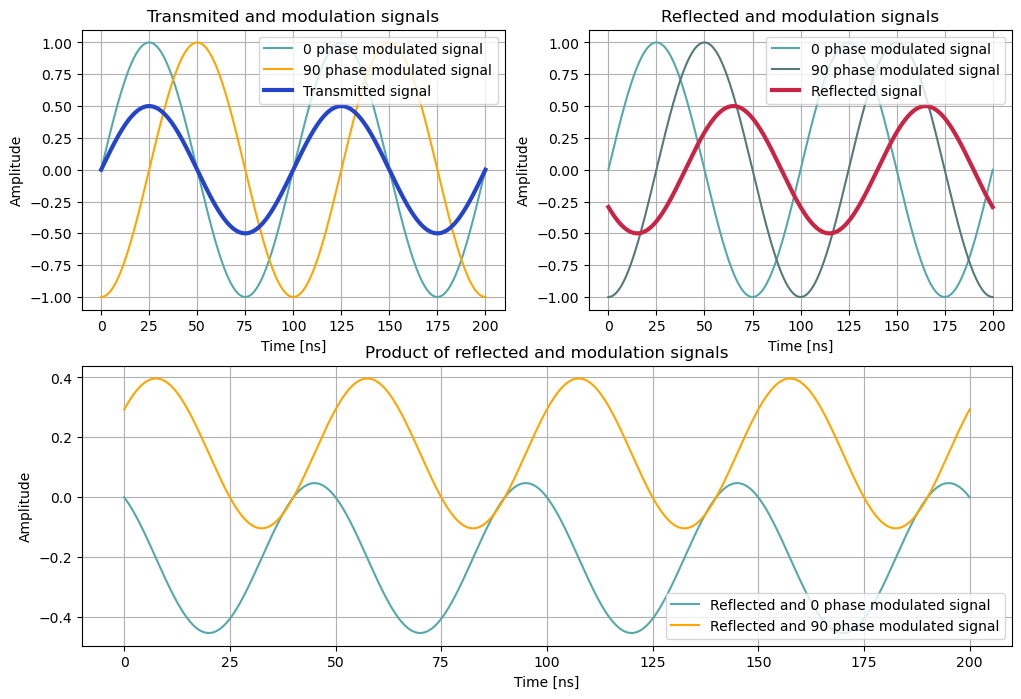

In [9]:
plot1()

### Izračuni

Zdaj lahko s pomočjo teh signalov in zgornjih enačb izračunamo spremebo faze odbitega signala in oddaljenost predmeta.

In [10]:
def integration_indexes(x, a, b):
    """
    Returns the indexes of the array x that are closest to the values a and b.
    """
    idx_a = np.argmin(np.abs(x - a))
    idx_b = np.argmin(np.abs(x - b))
    return idx_a, idx_b

In [11]:
def calculate(s_r, s_s_0, s_s_90):
    """
    Calculates the distance from the reflected signal and the modulation signals.
    """
    s_rs = s_r * s_s_0 
    s_r90s = s_r * s_s_90

    n = 3
    T_int = n * tp

    a, b = integration_indexes(t, 0, T_int)
    s_rs_int = np.trapz(s_rs[a:b], t[a:b])
    s_r90s_int = np.trapz(s_r90s[a:b], t[a:b]) 

    # Results
    pc_calc = np.arctan2(s_r90s_int, s_rs_int)

    d_calc = pc_calc * sc.c / (4 * np.pi * f)

    if pc_calc < 0:
        pc_calc += 2 * np.pi
    
    if d_calc <= 0:
        d_calc += sc.c / f / 2

    return pc_calc, d_calc

Preizkusimo funkcije, tako da generiramo signale za predmet na oddaljenosti 3m in preverimo, če dobimo pravilen rezultat.

In [12]:
d = 3

_, s_s_0, s_s_90 = get_laser_signals(t, f, I)
s_r = get_reflected_signal(t, f, I, d)

pc_calc, d_calc = calculate(s_r, s_s_0, s_s_90)
print("Izračunana fazna sprememba: {:.2f} rad".format(pc_calc))
print("Izračunana razdalja: {:.2f} m".format(d_calc))


Izračunana fazna sprememba: 1.26 rad
Izračunana razdalja: 3.00 m


In [13]:
def simulate(distances):
    """
    Simulates the IToF system. Returns calculated distances and phase changes for provided distances.
    
    returns:
    ds ... distances
    pc ... phase changes
    """
    pc = []
    ds = []
    _, s_s_0, s_s_90 = get_laser_signals(t, f, I)
    for d in distances:
        s_r = get_reflected_signal(t, f, I, d)
        pc_calc, d_calc = calculate(s_r, s_s_0, s_s_90)
        pc.append(pc_calc)
        ds.append(d_calc)
    
    return ds, pc

In [14]:
def plot_sim(simulation):
    distances = np.linspace(0, wl, 200)
    _, pc = simulation(distances)

    plt.figure(figsize=(12, 4))
    plt.title("Phase change for different distances")
    plt.plot(distances, pc, label="Calculated phase change", color= "#e3716f")
    plt.xlabel("Distance [m]")
    plt.ylabel("Phase change [rad]")
    plt.grid()
    plt.legend()
    plt.show()

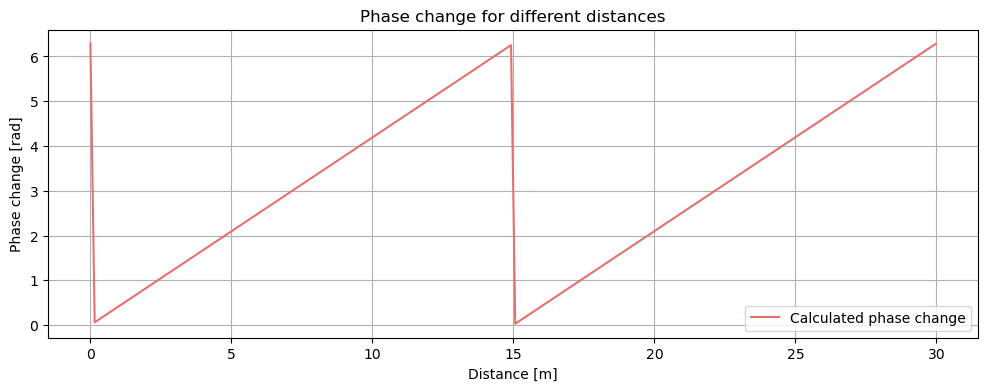

In [15]:
plot_sim(simulate)

Do preskokov na polovici valovne dolžine laserja pride, ker laser potuje celotno pot do predmeta in nazaj, torej je pri oddaljenost predmeta za polovico valovne dolžine prepotoval pot celotne valovne dolžine.

S to metodo lahko izračunana razdalja $d_i$ predstavlja katerokoli od dejanskih razdalj $d = d_i + k\dfrac{wl}{2} ; k \in \N$.

## Pozitivne vrednosti

Ker laser ne more oddajati svetlobe z negativno jakostjo (kot to predstavljajo trenutni sinusni signali), moramo spremeniti način generiranja signalov tako, da bodo ves čas pozitivni. 

Tako spreminjanje signalov nam malo pokvari enačbe, saj se pri integriranju periodični signali ne bodo več izničili.

Prirejene enačbe za nove signale:

\begin{align*}
T & = I \sin(2\pi f_m t) + E \\
S & = sin (2\pi f_m t) + M \\
\end{align*}

\begin{align*}
Q_0 & = \left[  \dfrac{\delta * I}{ 2} \cos(\Delta \varphi) + M(A + E)  \right] T_{int}  \\
Q_{90} & = \left[ - \dfrac{\delta * I}{ 2} \cos(\Delta \varphi) + M(A + E)  \right] T_{int} \\
Q_{180} & = \left[  \dfrac{\delta * I}{ 2} \sin(\Delta \varphi) + M(A + E)  \right] T_{int} \\
Q_{270} & = \left[ - \dfrac{\delta * I}{ 2} \sin(\Delta \varphi) + M(A + E)  \right] T_{int}
\end{align*}

\begin{align*}
\Delta\varphi = \arctg{\dfrac{Q_{90} - Q_{270}}{Q_0 - Q_{180}}}
\end{align*}


Določiti moramo parametra $E$ in $M$ ter dopolniti funkciji za generiranje signalov in izračun razdalje.

In [16]:
E = 4
M = 3

In [17]:
def get_laser_signals(t, f, I, E=0, M=0):
    """
    Generates the signals for the IToF system.
    t ... time
    f ... frequency
    I ... transmision signal intensity

    returns:
    T    ... Transmision signal
    S_0  ... 0 phase modulation signal 
    S_1  ... 90 phase modulation signal
    S_2  ... 180 phase modulation signal
    S_3  ... 270 phase modulation signal
    """
    T = I * np.sin(2 * np.pi * f * t) + E

    S_0 = np.sin(2 * np.pi * f * t) + M
    S_1 = np.sin(2 * np.pi * f * t - np.pi / 2) + M
    S_2 = np.sin(2 * np.pi * f * t - np.pi) + M
    S_3 = np.sin(2 * np.pi * f * t - 3 * np.pi / 2) + M

    return T, S_0, S_1, S_2, S_3

In [18]:
def get_reflected_signal(t, f, I, d, E=0):
    """
    Generates the reflected signal for the IToF system.
    t ... time
    f ... frequency
    I ... transmision signal intensity
    d ... distance

    returns:
    R    ... Reflected signal
    """
    R = I * np.sin(2 * np.pi * f * t - phase_change(f, d)) + E

    return R

In [19]:
def plot2():
    s_t, s_m_0, s_m_90, s_m_180, s_m_270 = get_laser_signals(t, f, I, E, M)
    s_r = get_reflected_signal(t, f, I, 6, E)

    s_rs = s_r * s_m_0 
    s_r90s = s_r * s_m_90
    s_r180s = s_r * s_m_180
    s_r270s = s_r * s_m_270

    n_periods = 2

    plt.figure(figsize=(12, 8))

    plt.subplot(2,2,1)
    plt.title("Transmited and modulation signals")
    plt.plot(t_ns[:n_periods*pp], s_m_0[:n_periods*pp], label="0 phase modulated signal", color="#55a9aa")
    plt.plot(t_ns[:n_periods*pp], s_m_90[:n_periods*pp], label="90 phase modulated signal", color="orange")
    plt.plot(t_ns[:n_periods*pp], s_t[:n_periods*pp], label="Transmitted signal", color="#2444ca", linewidth=3)
    plt.xlabel("Time [ns]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()

    plt.subplot(2,2,2)
    plt.title("Reflected and modulation signals")
    plt.plot(t_ns[:n_periods*pp], s_m_0[:n_periods*pp], label="0 phase modulated signal", color="#55a9aa")
    plt.plot(t_ns[:n_periods*pp], s_m_90[:n_periods*pp], label="90 phase modulated signal", color="#55797a")
    plt.plot(t_ns[:n_periods*pp], s_m_180[:n_periods*pp], label="180 phase modulated signal", color="#55595a")
    plt.plot(t_ns[:n_periods*pp], s_m_270[:n_periods*pp], label="270 phase modulated signal", color="#55292a")
    plt.plot(t_ns[:n_periods*pp], s_r[:n_periods*pp], label="Reflected signal", color="#ca2444", linewidth=3)
    plt.xlabel("Time [ns]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()

    plt.subplot(2,1,2)
    plt.title("Product of reflected and modulation signals")
    plt.plot(t_ns[:n_periods*pp], s_rs[:n_periods*pp], label="Reflected and 0 phase modulated signal", color="#55a9aa")
    plt.plot(t_ns[:n_periods*pp], s_r90s[:n_periods*pp], label="Reflected and 90 phase modulated signal", color="orange")
    plt.plot(t_ns[:n_periods*pp], s_r180s[:n_periods*pp], label="Reflected and 180 phase modulated signal", color="#55797a")
    plt.plot(t_ns[:n_periods*pp], s_r270s[:n_periods*pp], label="Reflected and 270 phase modulated signal", color="#55595a")

    plt.xlabel("Time [ns]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()#32302F

    plt.show()

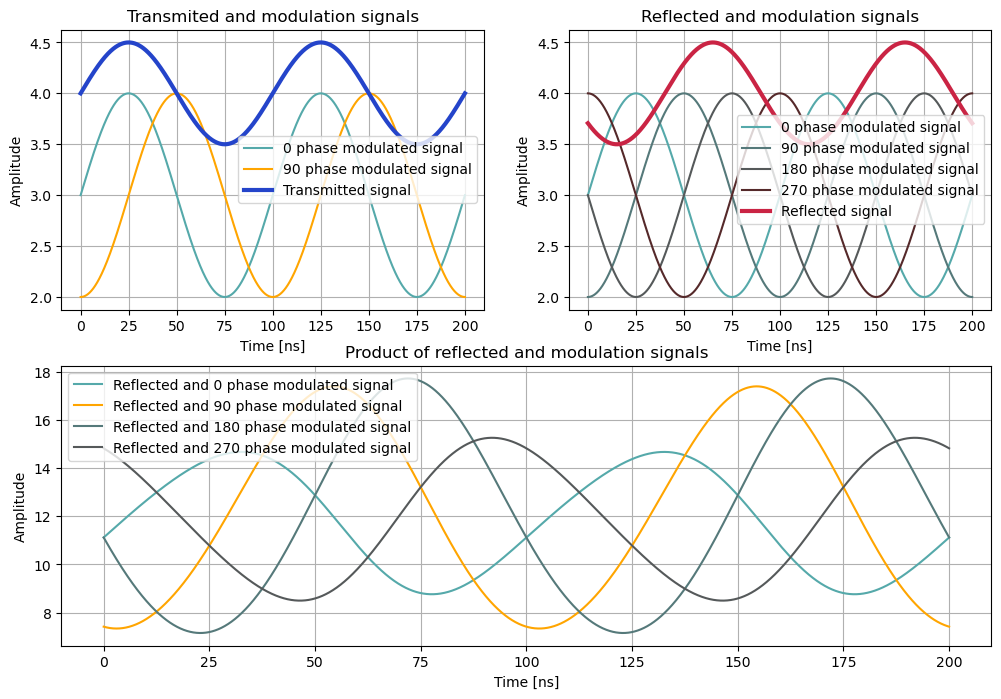

In [20]:
plot2()

In [21]:
def calculate(s_r, s_s_0, s_s_90, s_s_180=None , s_s_270=None):
    """
    Calculates the distance from the reflected signal and the modulation signals.
    """
    part2 = False
    if (s_s_180 is not None) and (s_s_270 is not None):
        part2 = True

    s_rs = s_r * s_s_0 
    s_r90s = s_r * s_s_90
    if part2:
        s_r180s = s_r * s_s_180
        s_r270s = s_r * s_s_270

    n = 3
    T_int = n * tp

    a, b = integration_indexes(t, 0, T_int)
    s_rs_int = np.trapz(s_rs[a:b], t[a:b])
    s_r90s_int = np.trapz(s_r90s[a:b], t[a:b]) 
    if part2:
        s_r180s_int = np.trapz(s_r180s[a:b], t[a:b]) 
        s_r270s_int = np.trapz(s_r270s[a:b], t[a:b])

    # Results
    if not part2:
        pc_calc = np.arctan2(s_r90s_int, s_rs_int)
    if part2:
        pc_calc = np.arctan2(s_r90s_int - s_r270s_int, s_rs_int - s_r180s_int)

    d_calc = pc_calc * sc.c / (4 * np.pi * f)

    if pc_calc < 0:
        pc_calc += 2 * np.pi
    
    if d_calc <= 0:
        d_calc += sc.c / f / 2

    return pc_calc, d_calc

In [22]:
def simulate2(distances):
    """
    Simulates the IToF system. Returns calculated distances and phase changes for provided distances.
    
    returns:
    ds ... distances
    pc ... phase changes
    """
    pc = []
    ds = []
    _, s_s_0, s_s_90, s_s_180, s_s_270 = get_laser_signals(t, f, I, E, M)
    for d in distances:
        s_r = get_reflected_signal(t, f, I, d)
        pc_calc, d_calc = calculate(s_r, s_s_0, s_s_90, s_s_180, s_s_270)
        pc.append(pc_calc)
        ds.append(d_calc)
    
    return ds, pc

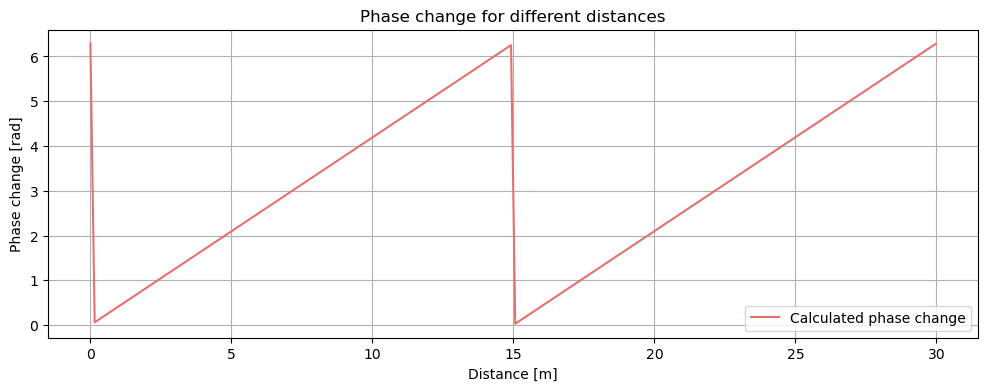

In [23]:
plot_sim(simulate2)

Iz zgornjega grafa je razvidno, da so rezultati popolnoma enaki, kot pri prvem primeru.

## Trapezoidni signali

Ker v elektroniki ne moremo imeti popolnih sinusnih signalov tako kot v zgornjih simulacijah, bomo v nadaljevanju generirali sistem z različnimi trapezoidnimi signali, in poskušali najti takega, pri katerem bodo rezultati najmanj popačeni.

Ramp up, ramp down, high in low vrednosti drapezoidnih bomo definirali globalno v obliki deleža periode.

In [24]:
# Pravokotni signal

ramp_up = 0.01
ramp_down = 0.01
high = 0.49
low = 0.49

In [25]:
def trapezoid_signal(l, ramp_up, ramp_down, high, low, n_points):
    """
    Generates a trapezoid signal.

    l         ... length of the signal
    ramp_up   ... time in percentage of the total time
    ramp_down ... time in percentage of the total time
    high      ... time in percentage of the total time
    low       ... time in percentage of the total time
    """
    if (n_points == 0):
        samples = l
    else:
        samples = n_points
    
    signal = np.zeros(samples)

    ramp_up_samples = int(ramp_up * samples)
    ramp_down_samples = int(ramp_down * samples)
    high_samples = int(high * samples)
    low_samples = int(low * samples)
    
    signal[:ramp_up_samples] = np.linspace(0, 1, ramp_up_samples)
    signal[ramp_up_samples:ramp_up_samples + high_samples] = 1
    signal[ramp_up_samples + high_samples:-low_samples] = np.linspace(1, 0, ramp_down_samples)
    signal[-low_samples:] = 0

    signal = np.tile(signal, int(len(t) / samples) + 1)
    return signal

In [26]:
def get_trapezoid_laser_signals(t, I, E=2, M=2):
    """
    t ... time
    I0 ... transmision signal intensity
    I1 ... reflection signal intensity

    returns:
    T ... Transmision signal
    R ... Reflection signal
    M_0 ... 0 phase modulation signal 
    M_1 ... 90 phase modulation signal
    M_2 ... 180 phase modulation signal
    M_3 ... 270 phase modulation signal
    """
    
    l = int(len(t) * 1.2)

    T = I * trapezoid_signal(l, ramp_up, ramp_down, high, low, pp) + E

    M_0 = trapezoid_signal(l, ramp_up, ramp_down, high, low, pp) + M
    M_1 = np.roll(M_0, int(- pp * 3 / 4))
    M_2 = np.roll(M_0, int(- pp * 2 / 4))
    M_3 = np.roll(M_0, int(- pp * 1 / 4))

    T = T[:len(t)]
    M_0 = M_0[:len(t)]
    M_1 = M_1[:len(t)]
    M_2 = M_2[:len(t)]
    M_3 = M_3[:len(t)]

    return T, M_0, M_1, M_2, M_3

In [27]:
def get_trapezoid_reflected_signal(t, f, I, d, E=0):
    l = int(len(t) * 1.2)
    R = I * np.roll(trapezoid_signal(l, ramp_up, ramp_down, high, low, pp), int(phase_change(f, d) / 2 / np.pi * pp)) + E
    R = R[:len(t)]
    return R

In [28]:
def plot3():
    s_t, s_m_0, s_m_90, s_m_180, s_m_270 = get_trapezoid_laser_signals(t, I, E, M)
    s_r = get_trapezoid_reflected_signal(t, f, I, 7.5, E)

    s_rs = s_r * s_m_0 
    s_r90s = s_r * s_m_90
    s_r180s = s_r * s_m_180
    s_r270s = s_r * s_m_270

    n_periods = 2

    plt.figure(figsize=(12, 8))

    plt.subplot(2,2,1)
    plt.title("Transmited and modulation signals")
    plt.plot(t_ns[:n_periods*pp], s_m_0[:n_periods*pp], label="0 phase modulated signal", color="#55a9aa")
    plt.plot(t_ns[:n_periods*pp], s_m_90[:n_periods*pp], label="90 phase modulated signal", color="orange")
    plt.plot(t_ns[:n_periods*pp], s_t[:n_periods*pp], label="Transmitted signal", color="#2444ca", linewidth=3)
    plt.xlabel("Time [ns]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()

    plt.subplot(2,2,2)
    plt.title("Reflected and modulation signals")
    plt.plot(t_ns[:n_periods*pp], s_m_0[:n_periods*pp], label="0 phase modulated signal", color="#55a9aa")
    plt.plot(t_ns[:n_periods*pp], s_m_90[:n_periods*pp], label="90 phase modulated signal", color="#55797a")
    plt.plot(t_ns[:n_periods*pp], s_m_180[:n_periods*pp], label="180 phase modulated signal", color="#55595a")
    plt.plot(t_ns[:n_periods*pp], s_m_270[:n_periods*pp], label="270 phase modulated signal", color="#55292a")
    plt.plot(t_ns[:n_periods*pp], s_r[:n_periods*pp], label="Reflected signal", color="#ca2444", linewidth=3)
    plt.xlabel("Time [ns]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()

    plt.subplot(2,1,2)
    plt.title("Product of reflected and modulation signals")
    plt.plot(t_ns[:n_periods*pp], s_rs[:n_periods*pp], label="Reflected and 0 phase modulated signal", color="#55a9aa")
    plt.plot(t_ns[:n_periods*pp], s_r90s[:n_periods*pp], label="Reflected and 90 phase modulated signal", color="orange")
    plt.plot(t_ns[:n_periods*pp], s_r180s[:n_periods*pp], label="Reflected and 180 phase modulated signal", color="#55797a")
    plt.plot(t_ns[:n_periods*pp], s_r270s[:n_periods*pp], label="Reflected and 270 phase modulated signal", color="#55595a")

    plt.xlabel("Time [ns]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()

    plt.show()

In [29]:
def simulate3(distances):
    """
    Simulates the IToF system. Returns calculated distances and phase changes for provided distances.
    
    returns:
    ds ... distances
    pc ... phase changes
    """
    pc = []
    ds = []
    _, s_s_0, s_s_90, s_s_180, s_s_270 = get_trapezoid_laser_signals(t, I, E, M)
    for d in distances:
        s_r = get_trapezoid_reflected_signal(t, f, I, d, E)
        pc_calc, d_calc = calculate(s_r, s_s_0, s_s_90, s_s_180, s_s_270)
        pc.append(pc_calc)
        ds.append(d_calc)
    
    return ds, pc

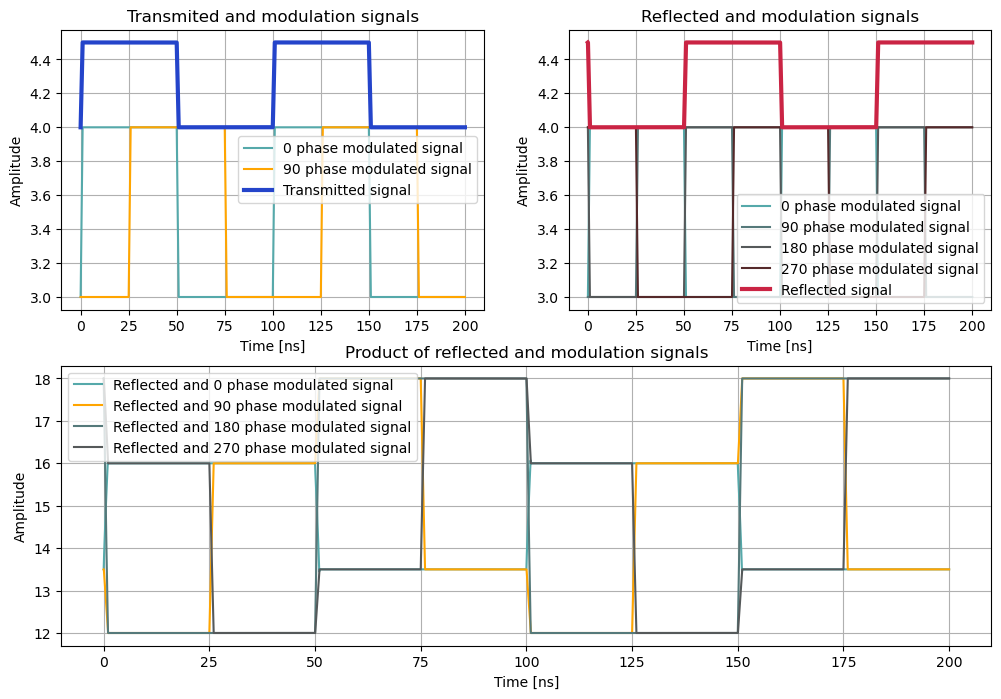

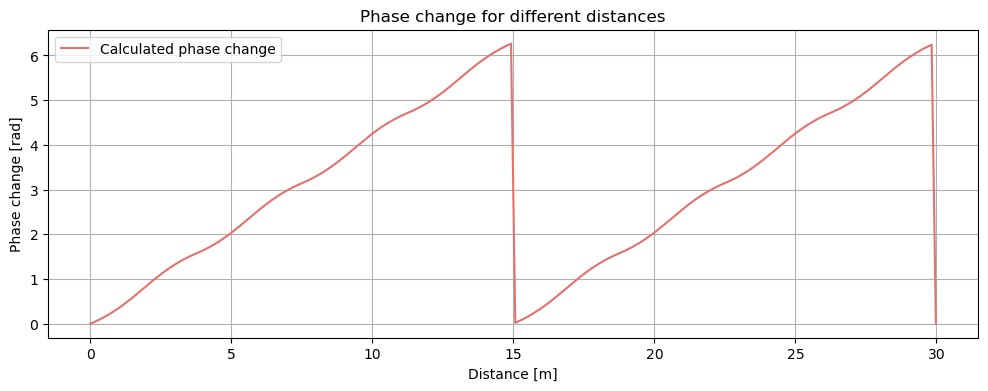

In [30]:
ramp_up = 0.01
ramp_down = 0.01
high = 0.49
low = 0.49

plot3()
plot_sim(simulate3)

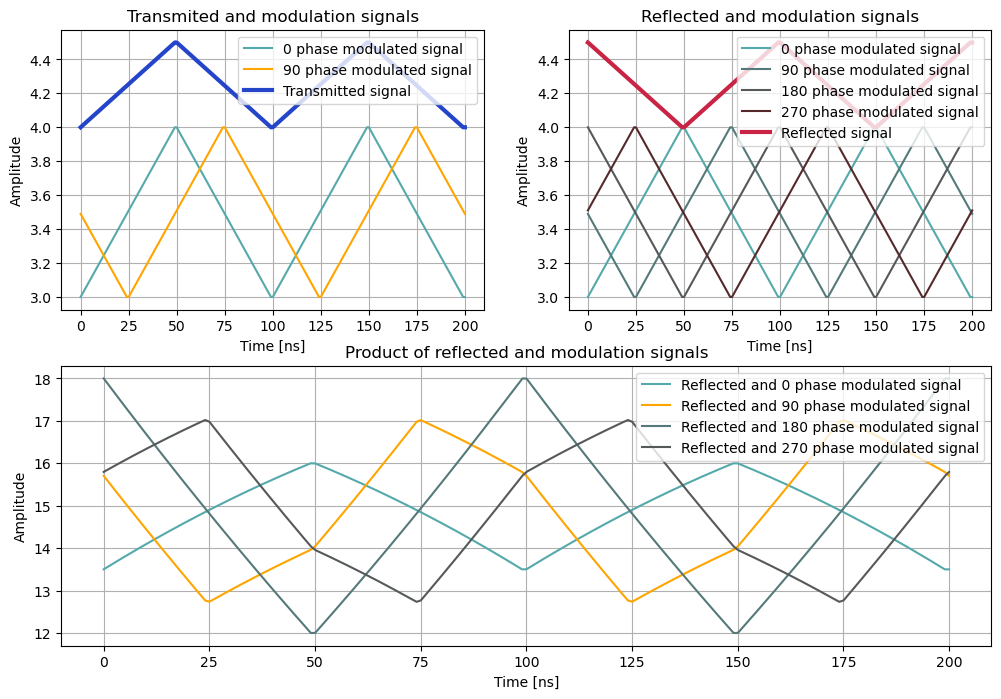

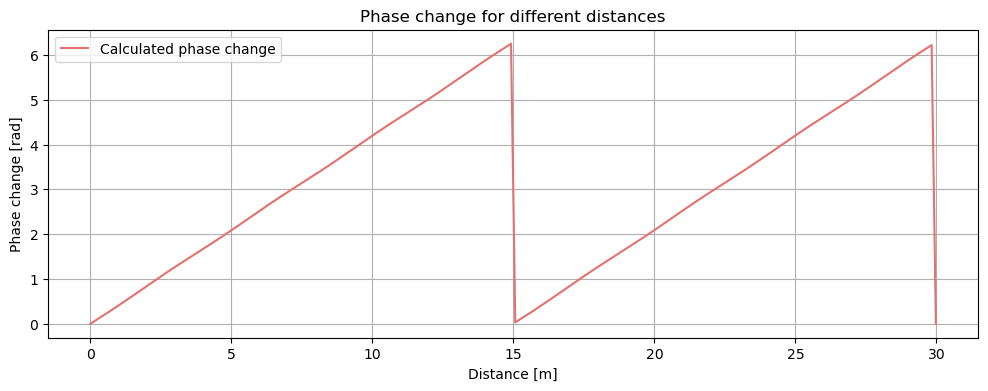

In [31]:
ramp_up = 0.49
ramp_down = 0.49
high = 0.01
low = 0.01

plot3()
plot_sim(simulate3)

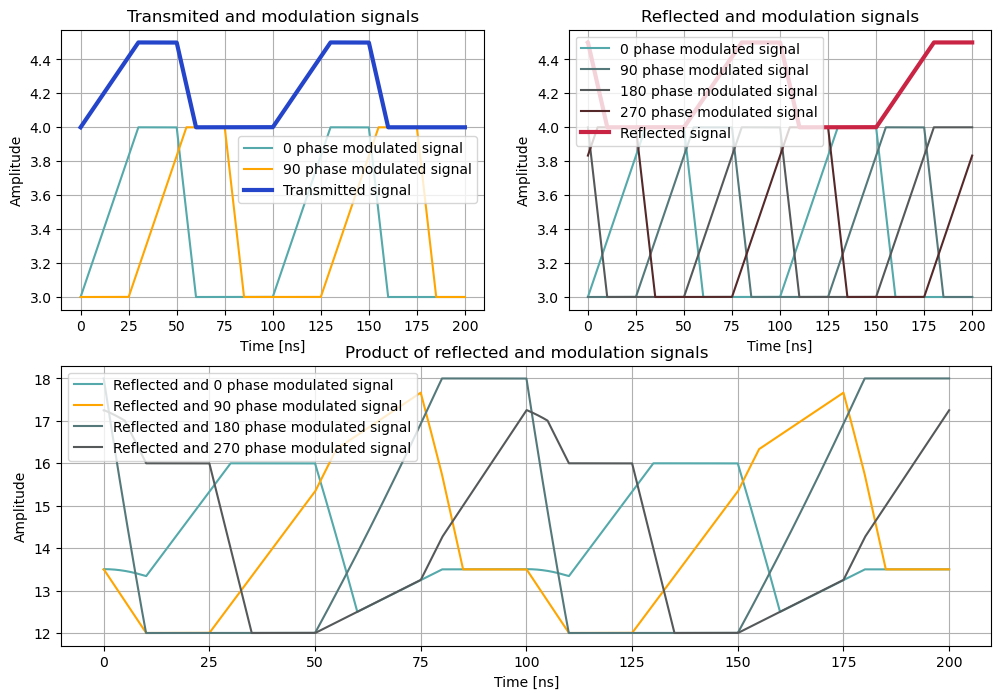

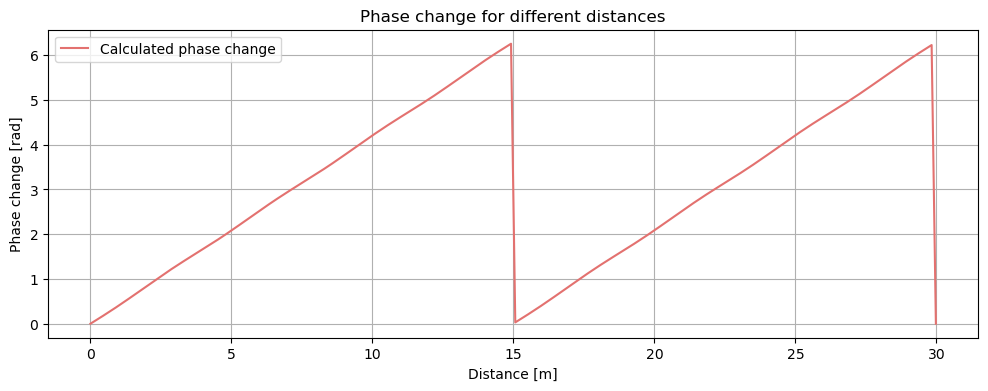

In [32]:
ramp_up = 0.3
ramp_down = 0.1
high = 0.2
low = 0.4

plot3()
plot_sim(simulate3)

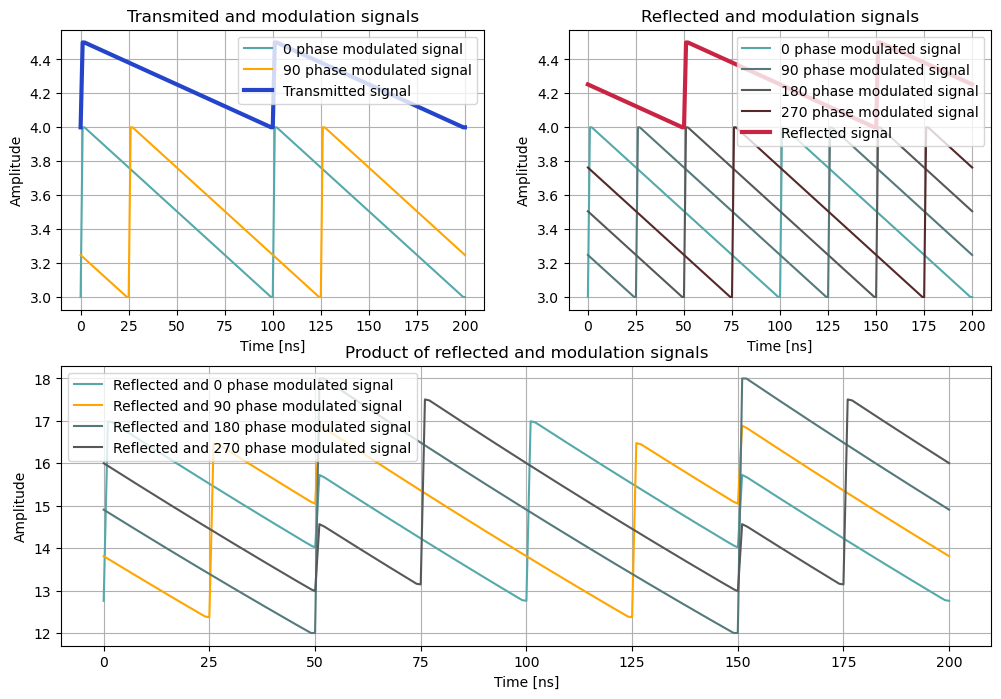

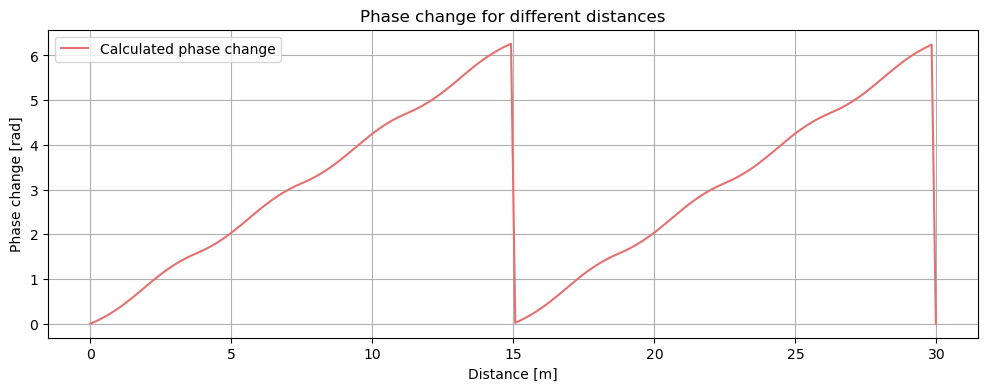

In [33]:
ramp_up = 0.01
ramp_down = 0.97
high = 0.01
low = 0.01

plot3()
plot_sim(simulate3)

Pri razlčnih trapezoidnih signalih opazimo, da izračunana fazna sprememba v odvisnosti od razdalje objekta različno odstopa od popolne linearne funkcije in pri mojem testiranju sem prišel do zaklička, da nam najlepši rezultat da trikotni signal.